# breakdown plots etc

In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.style
import matplotlib as mpl
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

mpl.style.use('ggplot')
print(mpl.style.available)

import cunusht

epsilons = [1e-12, 1e-06, 1e-02] # [1e-12, 1e-10, 1e-08, 1e-06]#, 1e-04, 1e-02]
runs = np.arange(1,6)
# np.array([36, 376,  876, 1216,  1576, 1876, 2188, 3088, 3376, 3676, 4376, 5104])-1
lmaxs = np.array([512*n-1 for n in np.arange(1,12)])
good_numbersp1 = np.array([36, 64, 76, 136, 148, 176, 244, 316, 344, 376,  568, 676, 736, 876, 1216, 1324, 1576, 1716, 1876, 2188, 2836, 3088, 3376, 3676, 4376, 5104])-1 #  6076, 6616, 7204, 7876])
lmaxs = np.array(sorted(np.concatenate([[], good_numbersp1]))).astype(int)
print(lmaxs, type(lmaxs), len(lmaxs))
blacklist_CPU, blacklist_GPU = [], []

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

def lmax2npoints(lmax):
    return (2*lmax)**2

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

def plot_breakdown(ress, keys, lmaxs, epsilons, lmaxids, title_str, fn, colors_up=plt.cm.Set3(np.linspace(0.05,.95,4)), colors_lp=plt.cm.Accent(np.linspace(0.1,0.8,len(epsilons)))):
    print(title_str.startswith('adjoint'), title_str)
    if title_str.startswith('adjoint'):
        # print('switched colors')
        colors = colors_up
    else:
        colors = colors_up
    fig, ax = plt.subplots(2,1,figsize=(5,10), sharex=False, sharey=False, gridspec_kw={'height_ratios': [3, 2]})
    fig.tight_layout()
    width = 80
    for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ress,axis=-1), np.std(ress,axis=-1))):
        total = np.sum(ressacc, axis=0)
        bottom = np.zeros(shape=(len(lmaxs[lmaxids])))
        for rowi, (row, err) in enumerate(zip(ressacc, errs)):
            # ax[0].bar((np.arange(len(lmaxs[::lmaxids])))+0.225*ressacci-0.125, (row/total)[::lmaxids]*100, 30*0.0075, align='center', bottom=bottom, yerr=(err/total)[::lmaxids]*100, capsize=0, edgecolor='black', label=keys[rowi] if ressacci==0 else "", color=colors[rowi])
            
            ax[0].bar(lmaxs[lmaxids]+width*ressacci-3/2*width, (row/total)[lmaxids]*100, width=width, bottom=bottom, yerr=(err/total)[lmaxids]*100, capsize=0, edgecolor='black', label=keys[rowi] if ressacci==0 else "", color=colors[rowi], align="edge")
            bottom += (row/total)[lmaxids]*100

    ax[0].set_title(title_str)
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles[::-1], labels[::-1], title='Component', loc='upper left')

    # ax[0].xaxis.set_major_locator(lmaxs[::lmaxids])
    ax[0].set_xticks(lmaxs[lmaxids])
    ax[0].set_xticklabels(lmaxs[lmaxids], rotation=40, ha='center')
    # ax[1].set_xlim(-0.3, len(lmaxs[::lmaxids]))
    
    ax[0].set_ylim(-5, 105)
    ax[0].yaxis.set_major_locator(MultipleLocator(20))
    ax[0].yaxis.set_major_formatter('{x:.0f}')
    ax[0].set_ylabel('Time [%]')

    lmax_acc_time = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T
    lmax_acc_time_err = np.array([[0. for a in range(len(lmaxs))] for n in range(len(epsilons))]).T
    for ni, n in enumerate(range(lmax_acc_time.shape[-1])):
        lmax_acc_time[:,n] = np.sum(np.mean(ress,axis=-1)[ni], axis=0)
        lmax_acc_time_err[:,n] = np.sum(np.std(ress,axis=-1)[ni], axis=0)

    for acc_datai, acc_data in enumerate(lmax_acc_time.T):
        # ax[1].fill_between(np.arange(len(lmaxs[::plot_every])), acc_data[::plot_every]-lmax_acc_time_err.T[acc_datai][::plot_every], (acc_data+lmax_acc_time_err.T[acc_datai])[::plot_every], alpha=0.6, label=r"$10^{{{:d}}}$".format(int(np.log10(epsilons[acc_datai]))))
        ax[1].fill_between(lmaxs, acc_data-lmax_acc_time_err.T[acc_datai], (acc_data+lmax_acc_time_err.T[acc_datai]), alpha=0.6, label=r"$10^{{{:d}}}$".format(int(np.log10(epsilons[acc_datai]))))
        # ax[1].plot(lmaxsGPU, acc_data, label=f'{epsilonsGPU[acc_datai]}', color=colors[acc_datai], lw=2)

    ax[1].legend(title='Target accuracy', loc='lower right')
    
    # ax[1].xaxis.set_major_locator(MultipleLocator(1))
    # ax[1].set_xticklabels(np.concatenate([[''],lmaxs[::plot_every]]), rotation=40, ha='center')
    # ax[1].set_xlim(-0.3, len(lmaxs[::plot_every]))
    ax[1].set_xscale('log')
    ax[1].set_xlabel(r'Multipole $\ell_{\rm max}$')  
    
    ax[1].set_ylabel('Total execution time / [s]')
    ax[1].set_yscale('log')
    if "DUCC" in title_str:
        ax[1].set_ylim(1e-4,2e0)
    else:
        ax[1].set_ylim(1e-3,6e-1)
    
    plt.savefig(os.environ['HOME']+"/output/"+fn+".pdf", bbox_inches='tight')
    

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
[  35   63   75  135  147  175  243  315  343  375  567  675  735  875
 1215 1323 1575 1715 1875 2187 2835 3087 3375 3675 4375 5103] <class 'numpy.ndarray'> 26


## lenmap2gclm

### load

In [17]:
popstr_runinfos_CPU = [
    ["CPU_Lenspyx_transformer"],
    ["init"],
    ["lenmap2gclm"],
    ["adjointsynthesisgeneral"],
    ["setup"],
    ["plane", "SphereInterpol setup", "borders"],
    ["dlm2pointing", "dlm2pointing - allocation", "dlm2pointing - dlm scaling"],
    ["pointing"],
    ["spin-1 synth"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["rotation", "rotate"],
    ["Transfers ->", "Transfer <-"],
]

planned = "planned"
popstrCPU = flatten_extend(popstr_runinfos_CPU)

runinfo = ('CPU', 'lenspyx')
blacklist_runinfos = []
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("CPU_Lenspyx_transformer", "lenmap2gclm") + "lmax{lmax}_epsilon{epsilon:1.0e}_run{run:02d}"

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilons:
    for lmax in lmaxs:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")
    
print("Loading files")
dataCPU = []
for epsilon in epsilons:
    _ = []
    for lmax in lmaxs:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataCPU.append(_)
    print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d1']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilons):
    popstr = popstrCPU
    for popstring in popstr:
        for d in dataCPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
          
ressCPU = []
sortedkeysCPU = [3,2,1,0]
keysCPU = np.array(list(dataCPU[0][0].keys()))[sortedkeysCPU]

print(keysCPU)
for epsiloni, epsilon in enumerate(epsilons):
    data_across_lCPU = {}
    for d in dataCPU[epsiloni]:
        for keyi, key in enumerate(keysCPU):
            if key in data_across_lCPU:
                data_across_lCPU[key].append(d[key])
            else:
                data_across_lCPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lCPU.items()])
    ressCPU.append(_)
    # print(epsilon, ressCPU[-1])
# print(ressCPU)
ressCPU = np.array(ressCPU)
print(ressCPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-12,1e-06,1e-02 and lmax in 35,63,75,135,147,175,243,315,343,375,567,675,735,875,1215,1323,1575,1715,1875,2187,2835,3087,3375,3675,4375,5103
All files found
Loading files
1e-12 0.53588
1e-06 0.47506000000000004
0.01 0.23052
['leg2alm' 'theta resampling' 'FFT' 'nuFFT2d1']
(3, 4, 26, 5) epsilon, keys, lmax


In [18]:
GPUid = "A100"
lmaxsGPU = lmaxs # np.array([512*n-1 for n in np.arange(1,11)])
epsilonsGPU = epsilons # [1e-12, 1e-10, 1e-08, 1e-06, 0.0001, 0.01] # [1e-14, 1e-12]# 1e-10, 1e-08, 1e-06]

popstr_runinfos_GPU = [
    ["GPU_cufinufft_transformer"],
    ["init - setup", "init - deflectionlib", "init - SHTlib", "init - allocation", "init - weights", "nuFFT and C2C - plan", "init"],
    ["lenmap2gclm"],
    ["adjointsynthesisgeneral"],
    ["setup"],
    ["nuFFT - init", "nuFFT - plan"],
    # ['nuFFT - exec', 'nuFFT - set points']
    ["dlm2pointing"],
    ["pointing"],
    ["spin-1 synth"],
    ["ascontiguousarray"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    # ["doubling"],
    ["rotation", "rotate"],
    ["Transfer ->", "Transfer <-"],
]

runinfo = ('GPU', 'cufinufft')
blacklist_runinfos = []
planned = "planned"
popstrGPU = flatten_extend(popstr_runinfos_GPU)
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("GPU_cufinufft_transformer", "lenmap2gclm") + "lmax{lmax}_epsilon{epsilon}_run{run:02d}_{gpuid}"
dataGPU = []


_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilonsGPU:
    for lmax in lmaxsGPU:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")

print("Loading files")
dataGPU = []
for epsilon in epsilonsGPU:
    _ = []
    for lmax in lmaxsGPU:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataGPU.append(_)
    print(len(dataGPU[0]), len(_))
    # print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d2']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilonsGPU):
    popstr = popstrGPU
    for popstring in popstr:
        for d in dataGPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
     
ressGPU = []
sortedkeysGPU = [3,2,1,0]
keysGPU = np.array(list(dataGPU[0][0].keys()))[sortedkeysGPU]
for epsiloni, epsilon in enumerate(epsilonsGPU):
    data_across_lGPU = {}
    for d in dataGPU[epsiloni]:
        for keyi, key in enumerate(keysGPU):
            if key in data_across_lGPU:
                data_across_lGPU[key].append(d[key])
            else:
                data_across_lGPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lGPU.items()])
    ressGPU.append(_)
    # print(epsilon, ressCPU[-1])
# print(ressCPU)
ressGPU = np.array(ressGPU)
print(ressGPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-12,1e-06,1e-02 and lmax in 35,63,75,135,147,175,243,315,343,375,567,675,735,875,1215,1323,1575,1715,1875,2187,2835,3087,3375,3675,4375,5103
All files found
Loading files
26 26
26 26
26 26
(3, 4, 26, 5) epsilon, keys, lmax


### plot

True adjoint_synthesis_general: DUCC


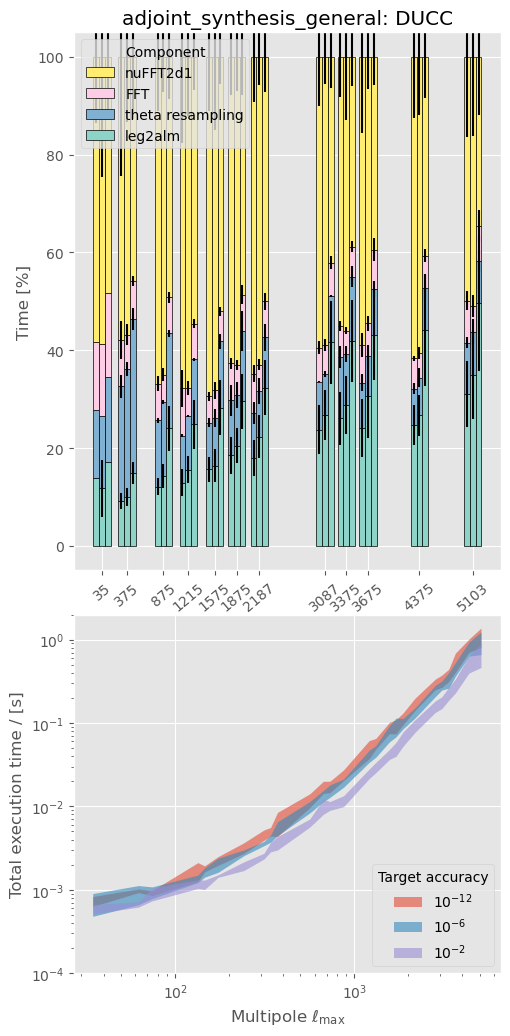

True adjoint_synthesis_general: cunuSHT


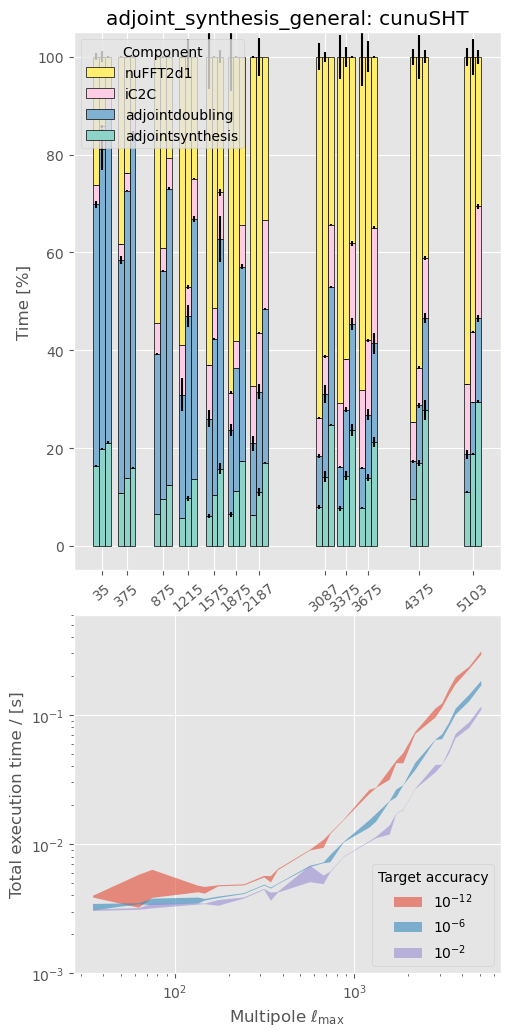

In [19]:
colors=plt.cm.Accent(np.linspace(0.1,0.8,len(epsilons)))
plotids = np.searchsorted(lmaxs, np.array([36, 376,  876, 1216,  1576, 1876, 2188, 3088, 3376, 3676, 4376, 5104])-1, side='right',sorter=np.argsort(lmaxs))-1
plot_breakdown(ressCPU, keysCPU, lmaxs, epsilons, plotids, "type 1 nuSHT: DUCC", 'adjoint_synthgen_CPU', colors_lp=colors)
plt.show()
plot_breakdown(ressGPU, keysGPU, lmaxsGPU, epsilonsGPU, plotids, f"type 1 nuSHT: cunuSHT - {GPUid}", 'adjoint_synthgen_GPU')

#### Speed up

3 [0.725 0.775 0.825 0.875 0.925 0.975]


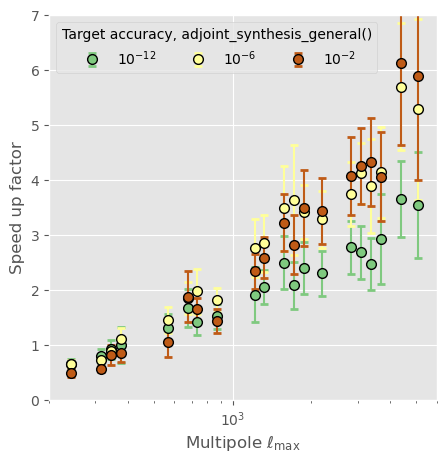

In [20]:
# colors = plt.cm.Set3(np.linspace(0.05,.95,len(epsilons)))
colors = plt.cm.Set2(np.linspace(0.1,0.7,len(epsilonsGPU)))
# colors = plt.cm.tab20(np.linspace(0.725,0.975,len(epsilonsGPU*2)))
print(len(colors), np.linspace(0.725,0.975,len(epsilonsGPU*2)))
colors = plt.cm.Accent(np.linspace(0.1,0.8,len(epsilons)))
fig, ax = plt.subplots(1,1,figsize=(5,5))

lmaxs_ = np.array([512*n-1 for n in np.arange(1,12)])
lmaxs2_ = good_numbersp1
sorter = np.argsort(lmaxs)
for li, l in enumerate([lmaxs2_]):
    for ressacci, (ressaccCPU, ressaccGPU, errsCPU, errsGPU) in enumerate(zip(np.mean(ressCPU,axis=(-1)), np.mean(ressGPU,axis=(-1)), np.std(ressCPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
        r = np.searchsorted(lmaxs, l, side='right',sorter=sorter)-1
        lmax_choice = lmaxs[r]
        totalC = np.sum(ressaccCPU, axis=0)
        totalG = np.sum(ressaccGPU, axis=0)
        
        totalerrC = np.sum(errsCPU, axis=0)
        totalerrG = np.sum(errsGPU, axis=0)
        
        # ax.plot(lmaxsGPU, totalC/totalG, label=list(epsilons)[ressacci], color=colors[ressacci], ls='-')
        ym = ((totalC-totalerrC-totalerrG)/totalG)[r]
        yp = ((totalC+totalerrC+totalerrG)/totalG)[r]
        yerr = ((totalerrC+totalerrG)/totalG)[r]
        ymean = (totalC/totalG)[r]
        alpha = 1.0 if li == 0 else 1.0
        markeredgecolor = 'black' if li == 0 else 'black'
        ms = 7 if li == 0 else 7
        # marker = 's' if li == 0 else 'D'
        # markerfacecolor=colors[ressacci], 
        ax.errorbar(lmax_choice, ymean, yerr, alpha=alpha, ms=ms, marker='o', markeredgecolor=markeredgecolor, color=colors[ressacci], capsize=3, capthick=2, ls='', label=r"$10^{{{:d}}}$".format(int(np.log10(epsilons[ressacci]))))#+"{}".format(", good numbers" if li==0 else ""))
        # ax.plot(lmax_choice, ymean, color=colors[ressacci+li], ls='-', label=r"$10^{{{:d}}}$".format(int(np.log10(epsilons[ressacci])))+", {}".format("good numbers" if li==1 else ""))
ax.legend(title='Target accuracy, type 1 nuSHT', loc='upper left', ncol=3)
ax.set_xlabel(r'Multipole $\ell_{\rm max}$')
ax.set_ylabel('Speed up factor')
ax.set_xlim(200,6000)
ax.set_ylim(0,7)
ax.set_xscale('log')
plt.savefig(os.environ['HOME']+"/output/adjoint_synthgen_speedup.pdf", bbox_inches='tight')

In [16]:
1e-12>1e-6

False

## gclm2lenmap

### load

In [2]:
popstr_runinfos_CPU = [
    ["CPU_Lenspyx_transformer"],
    ["init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["plane", "SphereInterpol setup", "borders"],
    ["dlm2pointing", "dlm2pointing - allocation", "dlm2pointing - dlm scaling"],
    ["pointing"],
    ["spin-1 synth"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["alm2leg", "theta resampling", "FFT"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["rotation", "rotate"],
    ["Transfers ->", "Transfer <-"],
]

planned = "planned"
popstrCPU = flatten_extend(popstr_runinfos_CPU)

runinfo = ('CPU', 'lenspyx')
blacklist_runinfos = []
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("CPU_Lenspyx_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon:1.0e}_run{run:02d}"

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilons:
    for lmax in lmaxs:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")
    
print("Loading files")
dataCPU = []
for epsilon in epsilons:
    _ = []
    for lmax in lmaxs:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataCPU.append(_)
    print(epsilon, len(dataCPU[0]), len(_))
    # print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d2']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilons):
    popstr = popstrCPU
    for popstring in popstr:
        for d in dataCPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
          
ressCPU = []
sortedkeysCPU = [2,0,1,3]
keysCPU = np.array(list(dataCPU[0][0].keys()))[sortedkeysCPU]
for epsiloni, epsilon in enumerate(epsilons):
    data_across_lCPU = {}
    for d in dataCPU[epsiloni]:
        for keyi, key in enumerate(keysCPU):
            if key in data_across_lCPU:
                data_across_lCPU[key].append(d[key])
            else:
                data_across_lCPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lCPU.items()])
    ressCPU.append(_)
    # print(epsilon, ressCPU[-1])
ressCPU = np.array(ressCPU)
print(ressCPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-12,1e-06,1e-02 and lmax in 35,63,75,135,147,175,243,315,343,375,567,675,735,875,1215,1323,1575,1715,1875,2187,2835,3087,3375,3675,4375,5103
All files found
Loading files
1e-12 26 26
1e-06 26 26
0.01 26 26
(3, 4, 26, 5) epsilon, keys, lmax


In [3]:
GPUdesc = "A100"
lmaxsGPU = lmaxs
epsilonsGPU = epsilons # [1e-12, 1e-10, 1e-08, 1e-06, 0.0001, 0.01] # [1e-12, 1e-10, 1e-08, 1e-06]
popstr_runinfos_GPU = [
    ["GPU_cufinufft_transformer"],
    ["init - setup", "init - deflectionlib", "init - SHTlib", "init - allocation", "init - weights", "nuFFT and C2C - plan", "init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["nuFFT - init", "nuFFT - plan"],
    # ['nuFFT - exec', 'nuFFT - set points']
    ["dlm2pointing"],
    ["pointing"],
    ["spin-1 synth"],
    ["ascontiguousarray"],
    # ["nuFFT2d2", "C2C", "synthesis"],
    # ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    # ["doubling"],
    ["rotation", "rotate"],
    ["Transfer ->", "Transfer <-"],
]

runinfo = ('GPU', 'cufinufft')
blacklist_runinfos = []
planned = "planned"
popstrGPU = flatten_extend(popstr_runinfos_GPU)
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("GPU_cufinufft_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon}_run{run:02d}_{GPUdesc}"
dataGPU = []

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilonsGPU:
    for lmax in lmaxsGPU:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run, GPUdesc=GPUdesc)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")

print("Loading files")
dataGPU = []
for epsilon in epsilonsGPU:
    _ = []
    for lmax in lmaxsGPU:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run, GPUdesc=GPUdesc)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataGPU.append(_)
    print(len(dataGPU[0]), len(_))
    # print(epsilon, np.mean(dataCPU[-1][-1]['nuFFT2d2']))
    # print(_)
# print(np.mean(dataCPU[0][-1]['nuFFT2d2']), np.mean(dataCPU[1][-1]['nuFFT2d2']))

for epsiloni, epsilon in enumerate(epsilonsGPU):
    popstr = popstrGPU
    for popstring in popstr:
        for d in dataGPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
     
ressGPU = []
sortedkeysGPU = [0,1,2,3]
keysGPU = np.array(list(dataGPU[0][0].keys()))[sortedkeysGPU]
for epsiloni, epsilon in enumerate(epsilonsGPU):
    data_across_lGPU = {}
    for d in dataGPU[epsiloni]:
        for keyi, key in enumerate(keysGPU):
            if key in data_across_lGPU:
                data_across_lGPU[key].append(d[key])
            else:
                data_across_lGPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lGPU.items()])
    ressGPU.append(_)
    # print(epsilon, ressCPU[-1])
# print(ressCPU)
ressGPU = np.array(ressGPU)
print(ressGPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-12,1e-06,1e-02 and lmax in 35,63,75,135,147,175,243,315,343,375,567,675,735,875,1215,1323,1575,1715,1875,2187,2835,3087,3375,3675,4375,5103
All files found
Loading files
26 26
26 26
26 26
(3, 4, 26, 5) epsilon, keys, lmax


### plot

False type 2 nuSHT: DUCC


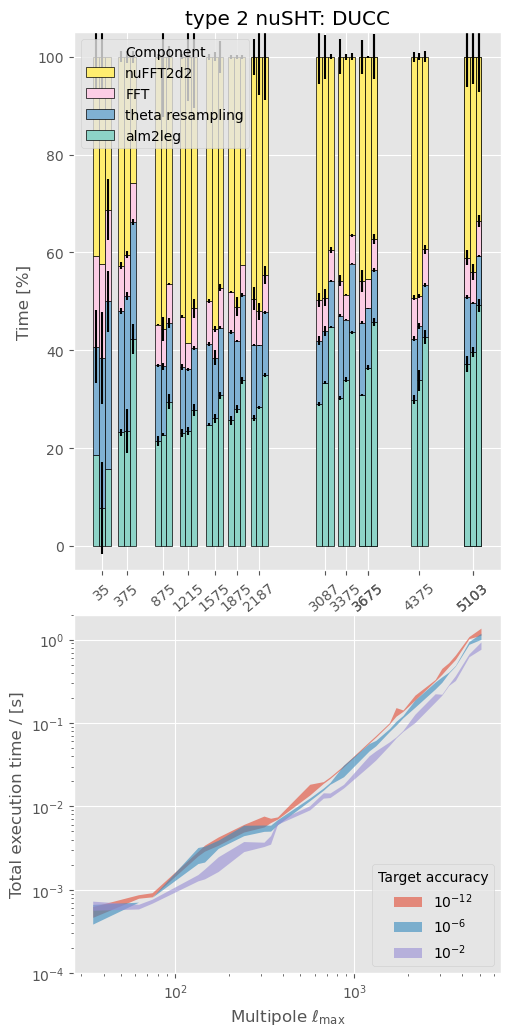

False type 2 nuSHT: cunuSHT


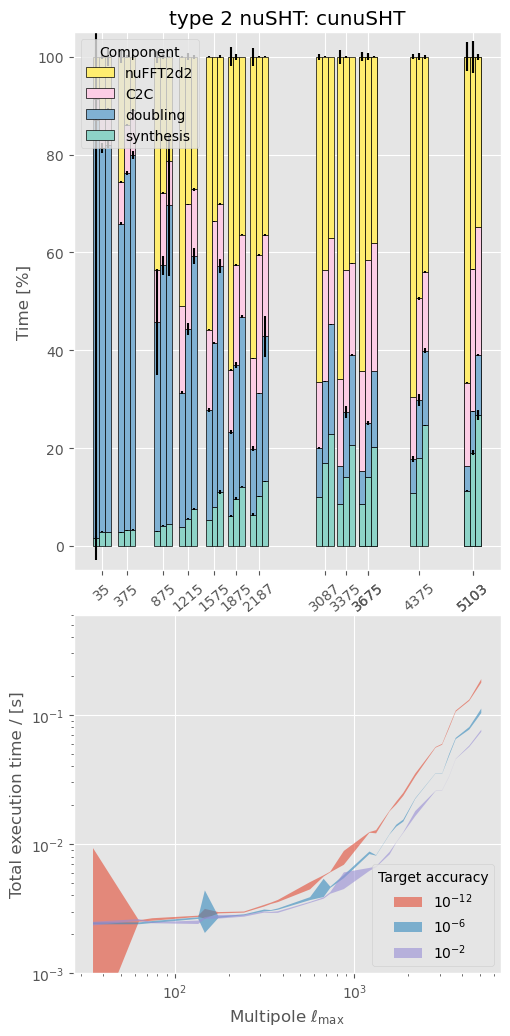

In [4]:
# 2559, 4095 non good numbers but plot anyway
plotids = np.searchsorted(lmaxs, np.array([36, 376,  876, 1216,  1576, 1876, 2188, 25, 4096, 3088, 3376, 3676, 4376, 5104])-1, side='right',sorter=np.argsort(lmaxs))-1
plot_breakdown(ressCPU, keysCPU, lmaxsGPU, epsilonsGPU, plotids, "type 2 nuSHT: DUCC", 'synthgen_CPU', colors_up=plt.cm.Set3(np.linspace(0.05,.95,4)), colors_lp=None)
plt.show()
plot_breakdown(ressGPU, keysGPU, lmaxsGPU, epsilonsGPU, plotids, "type 2 nuSHT: cunuSHT", 'synthgen_GPU')
plt.show()

#### Speed up

3 [0.725 0.775 0.825 0.875 0.925 0.975]


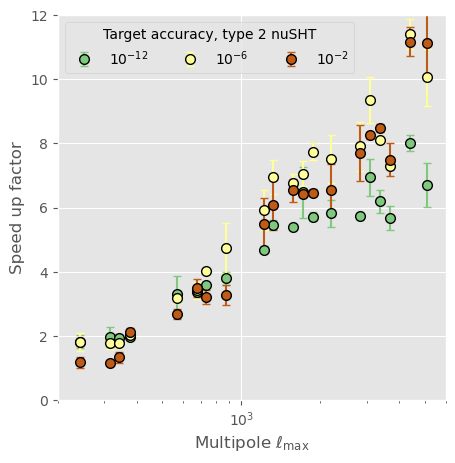

In [7]:
# colors = plt.cm.Set3(np.linspace(0.05,.95,len(epsilons)))
colors = plt.cm.Set2(np.linspace(0.1,0.7,len(epsilonsGPU)))
# colors = plt.cm.tab20(np.linspace(0.725,0.975,len(epsilonsGPU*2)))
print(len(colors), np.linspace(0.725,0.975,len(epsilonsGPU*2)))
colors = plt.cm.Accent(np.linspace(0.1,0.8,len(epsilons)))
fig, ax = plt.subplots(1,1,figsize=(5,5))

lmaxs_ = np.array([512*n-1 for n in np.arange(1,12)])
lmaxs2_ = good_numbersp1
sorter = np.argsort(lmaxs)
for li, l in enumerate([lmaxs2_]):
    for ressacci, (ressaccCPU, ressaccGPU, errsCPU, errsGPU) in enumerate(zip(np.mean(ressCPU,axis=(-1)), np.mean(ressGPU,axis=(-1)), np.std(ressCPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
        r = np.searchsorted(lmaxs, l, side='right',sorter=sorter)-1
        lmax_choice = lmaxs[r]
        totalC = np.sum(ressaccCPU, axis=0)
        totalG = np.sum(ressaccGPU, axis=0)
        
        totalerrC = np.sum(errsCPU, axis=0)
        totalerrG = np.sum(errsGPU, axis=0)
        
        # ax.plot(lmaxsGPU, totalC/totalG, label=list(epsilons)[ressacci], color=colors[ressacci], ls='-')
        ym = ((totalC-totalerrC-totalerrG)/totalG)[r]
        yp = ((totalC+totalerrC+totalerrG)/totalG)[r]
        yerr = ((totalerrC+totalerrG)/totalG)[r]
        ymean = (totalC/totalG)[r]
        alpha = 1.0 if li == 0 else 1.0
        markeredgecolor = 'black' if li == 0 else 'black'
        ms = 7 if li == 0 else 7
        marker = 'o' if li == 0 else 'D'
        # markerfacecolor=colors[ressacci], 
        ax.errorbar(lmax_choice, ymean, yerr, alpha=alpha, ms=ms, marker=marker, markeredgecolor=markeredgecolor, color=colors[ressacci], capsize=3, capthick=1, ls='', label=r"$10^{{{:d}}}$".format(int(np.log10(epsilons[ressacci]))))#+"{}".format(", good numbers" if li==0 else ""))
        # ax.plot(lmax_choice, ymean, color=colors[ressacci+li], ls='-', label=r"$10^{{{:d}}}$".format(int(np.log10(epsilons[ressacci])))+", {}".format("good numbers" if li==1 else ""))
ax.legend(title='Target accuracy, type 2 nuSHT', loc='upper left', ncol=3)
ax.set_xlabel(r'Multipole $\ell_{\rm max}$')
ax.set_ylabel('Speed up factor')
ax.set_xlim(200,6000)
ax.set_ylim(0,12)
ax.set_xscale('log')
plt.savefig(os.environ['HOME']+"/output/synthgen_speedup.pdf", bbox_inches='tight')

## Transfer / pointing (change popstring)

### load

In [154]:
lmaxsGPU=lmaxs
epsilonsGPU = epsilons # [1e-12, 1e-10, 1e-08, 1e-06]

popstr_runinfos_GPU = [
    ["GPU_cufinufft_transformer"],
    ["init - setup", "init - deflectionlib", "init - SHTlib", "init - allocation", "init - weights", "nuFFT and C2C - plan", "init"],
    ["gclm2lenmap"],
    ["synthesisgeneral"],
    ["setup"],
    ["nuFFT - init", "nuFFT - plan"],
    # ['nuFFT - exec', 'nuFFT - set points']
    # ["dlm2pointing"],
    ["pointing"],
    ["spin-1 synth"],
    ["ascontiguousarray"],
    ["nuFFT2d2", "C2C", "synthesis"],
    ["nuFFT2d2", "C2C", "doubling", "synthesis"],
    ["doubling"],
    ["rotation", "rotate"],
    ["Transfer ->", "Transfer <-"],
]

runinfo = ('GPU', 'cufinufft')
blacklist_runinfos = []
planned = "planned"
popstrGPU = flatten_extend(popstr_runinfos_GPU)
dirnames = os.path.dirname(cunusht.__file__)[:-8]+'/test/benchmark/timings/{}/{}/'
fns = dirnames.format("GPU_cufinufft_transformer", "gclm2lenmap") + "lmax{lmax}_epsilon{epsilon}_run{run:02d}"
dataGPU = []

_ = []
print(f"searching for all files with epsilon in " + ",".join([f"{ep:1.0e}" for ep in epsilons])+" and lmax in " + ",".join([f"{lm}" for lm in lmaxs])+"")
for epsilon in epsilonsGPU:
    for lmax in lmaxsGPU:
        for run in runs:
            fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
            if not os.path.isfile(fn):
                print(f"couldnt find {fn}")
                blacklist_runinfos.append(lmax)
if len(blacklist_runinfos)>0:
    print(f"Not found: {blacklist_runinfos}")
else:
    print("All files found")

print("Loading files")
dataGPU = []
for epsilon in epsilonsGPU:
    _ = []
    for lmax in lmaxsGPU:
        if lmax not in blacklist_runinfos:
            mergedict = {}
            for run in runs:
                fn = fns.format(backend=runinfo[0], solver=runinfo[1], lmax=lmax, epsilon=epsilon, planned=planned, run=run)
                with open(fn, "r") as file:
                    newdict = json.load(file)
                    for key in newdict.keys():
                        if key in mergedict:
                            mergedict[key] = mergedict[key] + [newdict[key]]
                        else:
                            mergedict[key] = [newdict[key]]
            _.append(mergedict)
        else:
            print(f"not appending {lmax} to {runinfo}")
    dataGPU.append(_)
    print(len(dataGPU[0]), len(_))

for epsiloni, epsilon in enumerate(epsilonsGPU):
    popstr = popstrGPU
    for popstring in popstr:
        for d in dataGPU[epsiloni]:
            if popstring in d:
                d.pop(popstring)
    # print(epsilon, dataCPU[epsiloni])
     
ressGPU = []
keysGPU = np.array(list(dataGPU[0][0].keys()))#[[1,0,2,3]]
for epsiloni, epsilon in enumerate(epsilonsGPU):
    data_across_lGPU = {}
    for d in dataGPU[epsiloni]:
        for keyi, key in enumerate(d.keys()):
            if key in data_across_lGPU:
                data_across_lGPU[key].append(d[key])
            else:
                data_across_lGPU[key] = [d[key]]
    _ = np.array([v for k, v in data_across_lGPU.items()])
    ressGPU.append(_)
ressGPU = np.array(ressGPU)
print(ressGPU.shape, "epsilon, keys, lmax")

searching for all files with epsilon in 1e-12,1e-10,1e-08,1e-06,1e-04,1e-02 and lmax in 511,1023,1535,2047,2559,3071,3583,4095,4607,5119,5631
All files found
Loading files
11 11
11 11
11 11
11 11
11 11
11 11
(6, 1, 11, 10) epsilon, keys, lmax


### Transfer etc

In [18]:
runinfo = ('GPU', 'cufinufft')
colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
fig, ax = plt.subplots(1,1,figsize=(6,6))

for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressGPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
    for rowi, (row, err) in enumerate(zip(ressacc, errs)):
        ax.fill_between(lmaxsGPU, row-err, row+err, label=list(keysGPU)[rowi] if ressacci==0 else "", color=colors[rowi], ls='-')
        # ax.plot(lmaxsGPU, row, lw=2, color='black')
ax.legend(title=None, loc='upper left')
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Transfer time / [s]')
# ax[1].set_xscale('log')
ax.set_yscale('log')
plt.show()

runinfo = ('GPU', 'cufinufft')
colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
fig, ax = plt.subplots(1,1,figsize=(6,6))

for ressacci, (ressacc, errs) in enumerate(zip(np.mean(ressGPU,axis=(-1)), np.std(ressGPU,axis=(-1)))):
    for rowi, (row, err) in enumerate(zip(ressacc, errs)):
        ax.fill_between(lmaxsGPU, row-err, row+err, label=list(keysGPU)[rowi] if ressacci==0 else "", color=colors[rowi], ls='-')
        # ax.plot(lmaxsGPU, row, lw=2, color='black')
ax.legend(title=None, loc='upper left')
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Execution time / [s]')
# ax[1].set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2, 1e0)
plt.show()

runinfo = ('GPU', 'cufinufft')
colors = plt.cm.Set3(np.linspace(0,1.0,len(keysGPU)))
fig, ax = plt.subplots(1,1,figsize=(10,3))

for ressacci, (ressaccCPU, ressaccGPU) in enumerate(zip(np.mean(ressCPU,axis=(-1)), np.mean(ressGPU,axis=(-1)))):
    for rowi, (rowC, rowG) in enumerate(zip(ressaccCPU, ressaccGPU)):
        ax.plot(lmaxsGPU, rowC/rowG, label=list(keysGPU)[rowi] if ressacci==0 else "", color=colors[rowi], ls='-')
        # ax.plot(lmaxsGPU, row, lw=2, color='black')
ax.legend(title=None, loc='upper left')
ax.set_xlabel('Multipole $\ell$')    
ax.set_ylabel('Speed up factor')
# ax[1].set_xscale('log')
# ax.set_yscale('log')

1.702128e-09